In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib as mlp
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sn
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
with open ('../models/catboost.pkl', 'rb') as f:
    clf = pickle.load(f)
    
df = pd.read_csv('../data/Task2data.csv')
y = df.pop('fraud')

X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=7, stratify=y)

In [3]:
preds_proba = clf.predict_proba(X_test)[:, 1]

#### Start by looking at out model's default confusion matrix
You can see that we only correctly identify just over half of our fraud labels. <br>
In some business scenarios this would not be very good, however note that our typical transaction amount is not very high.

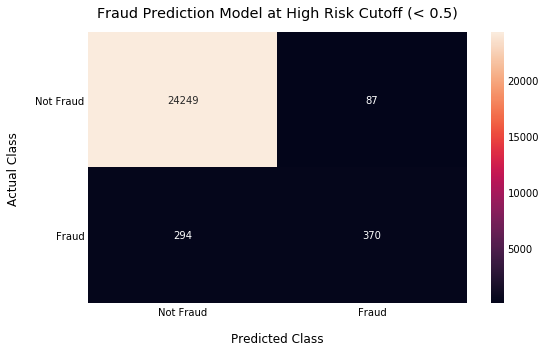

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
#Catboost Classifier, like most Random Forest Models, classifies all rows of data 
    #with probability higher than 0.5 as a positive (or fraud in this case)
    #I calculate the what classifies as fraud here explicitly to illustrate how we can manipulate this when necessary
confusion_matrix = metrics.confusion_matrix(y_test, (preds_proba > .5).astype(int))

sn.heatmap(confusion_matrix, fmt='', annot=True, cbar=True, ax=ax)
ax.set_xlabel('Predicted Class', labelpad=15)
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud'])
ax.set_ylabel('Actual Class', labelpad=15)
ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'], rotation=360)
ax.set_title('Fraud Prediction Model at High Risk Cutoff (< 0.5)', pad=15)
fig.tight_layout()
#plt.savefig('../visuals/confusion_default.png')

#### Next we define the cost of classification
In this case, we're looking at loss mitigation so our default is 0 dollars. The average transaction amount in this data set is about 27 dollars so we could say not catching a case of fraud accordingly. Let's imagine it costs us 15 dollars of manhours to investigate fraud and we don't expect any user churn from incorrectly flagging fraud (so it's also 15 dollars). To calculate our expected losses we simply multiply the classifier's confusion matrix by the outlined cost/benefit matrix.

In [5]:
cb_matrix = pd.DataFrame(data=[[0, -15.0], [-27.00, -15.0]], 
                         index=['Legal', 'Fraud'], columns=['Legal', 'Fraud'])
cb_matrix.index.name = 'actual'
cb_matrix.columns.name = 'predicted'
cb_matrix

predicted,Legal,Fraud
actual,,
Legal,0.0,-15.0
Fraud,-27.0,-15.0


In [6]:
def calculate_payout(cb, y_true, probabilities, threshold):
    preds = (probabilities > threshold).astype(int)
    confusion_matrix = metrics.confusion_matrix(y_true, preds)
    payout = (cb * confusion_matrix).values.sum()
    return payout

In [7]:
def plot_moving_threshold(thresholds, cb_matrix):
    profits = []
    for threshold in thresholds:
        profits.append(calculate_payout(cb_matrix, y_test, preds_proba, threshold))
    max_profit = thresholds[np.argmax(profits)]

    fig, ax = plt.subplots(figsize=(9,6))
    ax.axvline(max_profit, linewidth=1, linestyle='--', color='k')
    ax.plot(thresholds, profits, linewidth=2)
    ax.yaxis.set_major_formatter(mlp.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.set_xlim([0,1])
    ax.axes.xaxis.set_ticklabels(['',0.2,0.4,0.6,0.8,1.0])
    ax.set_xlabel(f'Thresholds -- Maximum at {round(max_profit, 3)}', labelpad=20)
    ax.set_ylabel('Expected Loss ($)', labelpad=20)
    ax.set_title('Fraud loss at different probability thresholds', pad=15)
    plt.tight_layout()

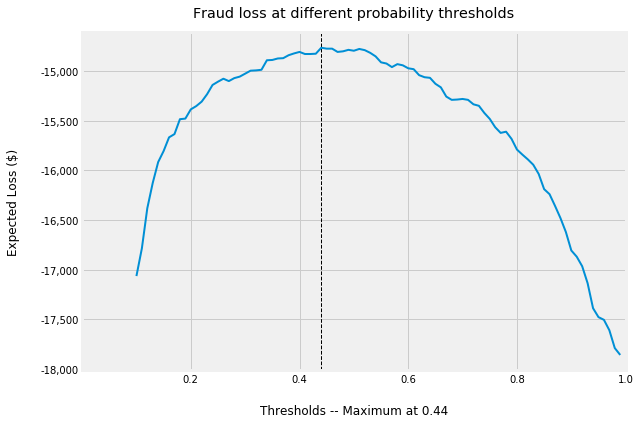

In [8]:
thresholds = np.arange(0.1, 1.0, 0.01)
plot_moving_threshold(thresholds, cb_matrix)
#plt.savefig('../visuals/default_profitcurve.png')

#### Now let's say it takes a few moments to review fraud - say, 2 dollars
Note that we can accept far more false positives, which also gets us more cases of fraud accurately labelled

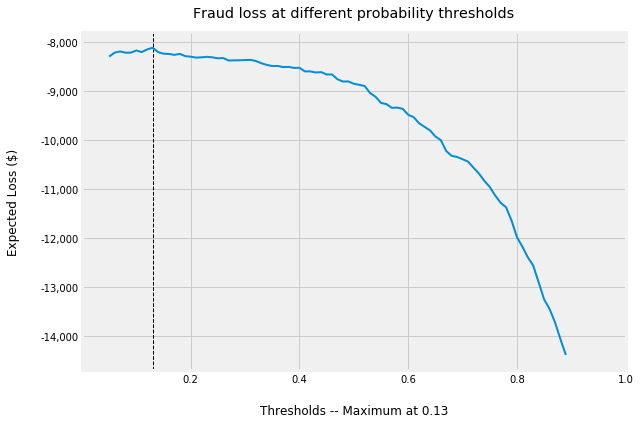

In [9]:
cb_matrix = pd.DataFrame([[0.0, -2.0], [-27.00, -2.0]])
thresholds = np.arange(0.05, 0.9, 0.01)
plot_moving_threshold(thresholds, cb_matrix)
#plt.savefig('../visuals/cheapreview_profitcurve.png')

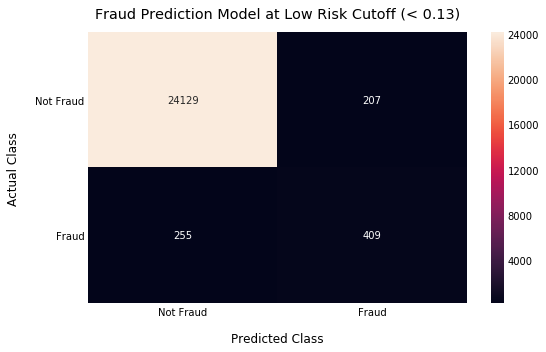

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
confusion_matrix = metrics.confusion_matrix(y_test, (preds_proba > .13).astype(int))

sn.heatmap(confusion_matrix, fmt='', annot=True, cbar=True, ax=ax)
ax.set_xlabel('Predicted Class', labelpad=15)
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud'])
ax.set_ylabel('Actual Class', labelpad=15)
ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'], rotation=360)
ax.set_title('Fraud Prediction Model at Low Risk Cutoff (< 0.13)', pad=15)
fig.tight_layout()
#plt.savefig('../visuals/confusion_low.png')

#### Now let's say it costs about 5 dollars to review fraud but we expect to lose 75 dollars from user churn 
This is a bit of a ridiculous scenario, but I just want to illustrate how this changes the curve
Note that we can accept far fewer false positives, which also gets us fewer fraud cases accurately labelled

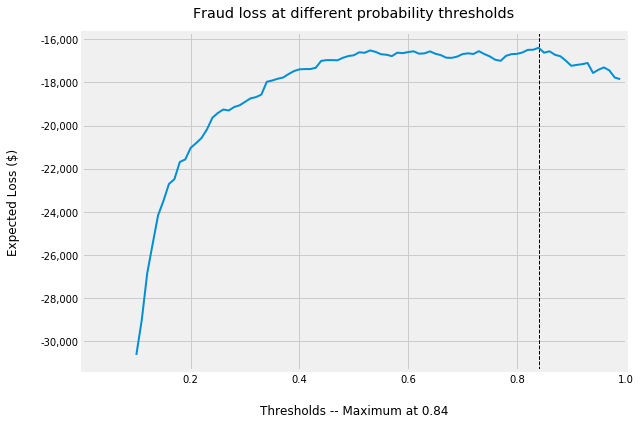

In [11]:
cb_matrix = pd.DataFrame([[0.0, -80.0], [-27.00, -5.0]])
thresholds = np.arange(0.1, 1.0, 0.01)
plot_moving_threshold(thresholds, cb_matrix)
#plt.savefig('../visuals/churny_profitcurve.png')

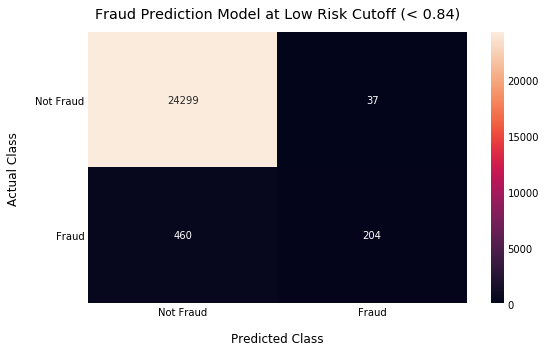

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
confusion_matrix = metrics.confusion_matrix(y_test, (preds_proba > .84).astype(int))

sn.heatmap(confusion_matrix, fmt='', annot=True, cbar=True, ax=ax)
ax.set_xlabel('Predicted Class', labelpad=15)
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud'])
ax.set_ylabel('Actual Class', labelpad=15)
ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'], rotation=360)
ax.set_title('Fraud Prediction Model at Low Risk Cutoff (< 0.84)', pad=15)
fig.tight_layout()
#plt.savefig('../visuals/confusion_high.png')